# Разработка системы распознавания предметов интерьера в потоковом видео
## Часть 6: Предсказания

In [73]:
%matplotlib inline

# System
import os
import sys
import datetime
import time

# Base
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow
import seaborn as sns

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

# Preprocessing
from keras.utils import Sequence, to_categorical
from keras.utils.vis_utils import plot_model

# Backend
import tensorflow as tf
from keras import backend as K
from tensorflow.python.client import device_lib

# Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

In [2]:
from scripts_.PathFinder import PathFinder
from scripts_.SegEncoder import SegEncoder
from scripts_.ClassList import ClassList

pf = PathFinder()
se = SegEncoder()
cl = ClassList(load_class_encode=True, class_encode_path="static/class_encode.txt")

img_dir = 'data/ADE20K_filtred/images/'

In [3]:
class def_config:

    main_data_dir = "data/ADE20K_encoded/"
    callbacks_dir = "callbacks/"

    img_shape = 256
    classes_num = 31

    batch_size = 4
    epoch_num = 1
    train_coef = 1
    learning_rate = 0.0001

    last_activation = "sigmoid"
    loss_function = "categorical_crossentropy"

    gpu_memory_limit = 0.8
    cpu_threads_num = 4

    callbacks_monitor = "val_jaccard_coef"
    callbacks_data_format = "%m.%d_%H-%M"
    file_name = "DefName"
    
    is_load = True
    weight_path = "callbacks/Unet_3_64_512_sigmoid_06.01_06-22/best_w_loss.h5"
    
    argparse_is_on = False
    
    
args = def_config()

In [4]:
main_data_dir = args.main_data_dir

train_dir = main_data_dir + "train/"
val_dir = main_data_dir + "val/"

img_train_dir = train_dir + "img/"
mask_train_dir = train_dir + "mask/"

img_val_dir = val_dir + "img/"
mask_val_dir = val_dir + "mask/"

####################################

img_shape = args.img_shape
batch_size = args.batch_size
classes_num = args.classes_num

epoch_num = args.epoch_num
train_coef = args.train_coef
learning_rate = args.learning_rate

loss_function = args.loss_function
last_activation = args.last_activation

is_load = args.is_load
if is_load:
    weight_path = args.weight_path
else:
    weight_path = None

In [5]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((2. * intersection + smooth) / 
            (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def jaccard_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / 
            (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

In [6]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

In [7]:
def data_gen(img_dir, mask_dir, classes_num, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir

    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)

    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0]  # отделяем имя от формата

    counter = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, classes_num)).astype("uint8")

        for i in range(counter, counter + batch_size):
            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") / 255.
            train_img = cv2.resize(train_img, (img_shape, img_shape))

            img[i - counter] = train_img

            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation=cv2.INTER_NEAREST)
            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=classes_num)

            mask[i - counter] = train_mask

        counter += batch_size

        if counter + batch_size >= img_dir_size:
            counter = 0
            random.shuffle(img_list)

        yield img, mask


train_gen = data_gen(img_train_dir, mask_train_dir, classes_num=classes_num, batch_size=batch_size)
val_gen = data_gen(img_val_dir, mask_val_dir, classes_num=classes_num, batch_size=batch_size)

In [8]:
def get_model(img_shape, classes_num, last_activation):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_conv3 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv2)
    block4_upsa1 = UpSampling2D(2, interpolation="bilinear")(block4_conv3)

    block5_conc1 = Concatenate()([block3_conv3, block4_upsa1])
    block5_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conc1)
    block5_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv1)
    block5_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv2)
    block5_upsa1 = UpSampling2D(2, interpolation="bilinear")(block5_conv3)

    block6_conc1 = Concatenate()([block2_conv3, block5_upsa1])
    block6_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv2)
    block6_upsa1 = UpSampling2D(2, interpolation="bilinear")(block6_conv3)

    block7_conc1 = Concatenate()([block1_conv3, block6_upsa1])
    block7_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv2)

    block8_output = Conv2D(classes_num, (1, 1), padding="same", activation=last_activation)(block7_conv3)

    return Model(inputs=block0_input, outputs=block8_output)

In [9]:
model = get_model(None, classes_num, last_activation)

model.load_weights(weight_path)

if is_load:
    if not weight_path:
        raise ValueError("Don't load weight_path")
    model.load_weights(weight_path)

if loss_function == 'categorical_crossentropy':
    pass
elif loss_function == 'dice_loss':
    loss_function = dice_loss
elif loss_function == 'jaccard_loss':
    loss_function = jaccard_loss
else:
    raise ValueError("Incorrect loss function :" + loss_function)

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss_function,
              metrics=["accuracy", dice_coef, jaccard_coef])

In [10]:
cl.class_list

[['-'],
 ['chair'],
 ['painting, picture', 'drawing', 'tapestry, tapis'],
 ['cabinet'],
 ['table', 'desk'],
 ['door'],
 ['plant, flora, plant life'],
 ['bed'],
 ['pillow', 'cushion'],
 ['armchair'],
 ['person, individual, someone, somebody, mortal, soul'],
 ['sofa, couch, lounge'],
 ['rug, carpet, carpeting'],
 ['sink'],
 ['swivel chair'],
 ['stool'],
 ['chest of drawers, chest, bureau, dresser'],
 ['stove, kitchen stove, range, kitchen range, cooking stove'],
 ['computer, computing machine, computing device, data processor, electronic computer, information processing system'],
 ['bathtub, bathing tub, bath, tub'],
 ['refrigerator, icebox'],
 ['wardrobe, closet, press'],
 ['microwave, microwave oven'],
 ['monitor, monitoring device',
  'television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box',
  'screen, crt screen'],
 ['hood, exhaust hood'],
 ['oven'],
 ['laptop, laptop computer'],
 ['counter', 'work surface', 'kitchen island', 'countertop'

In [150]:
def pred_img(path):
    img = imread(path)
    img = cv2.resize(img, (img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    for i in range(31):
        mask = pred[:, :, i]
        print(np.sum(mask > 0.5) / img_shape /img_shape)
        
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask > 0.3, cmap="gray", norm=None)
        
        plt.title(cl.class_list[i])
        plt.show()
    return img, pred

0.6988372802734375


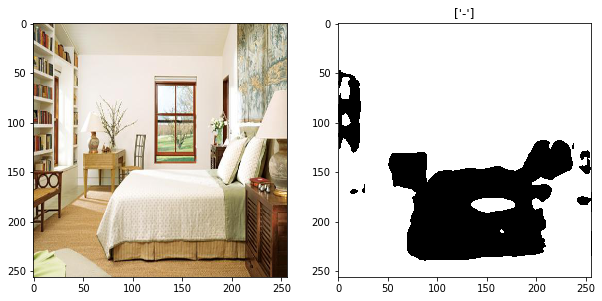

0.0120849609375


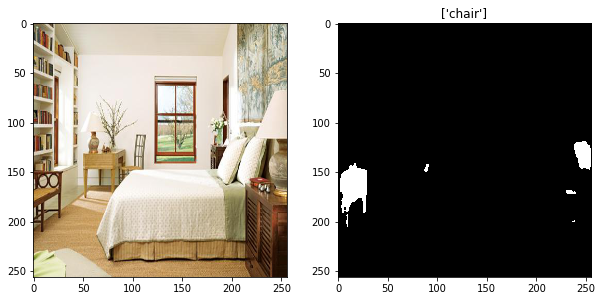

0.0


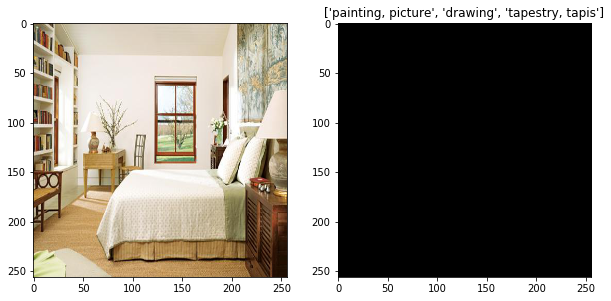

0.0


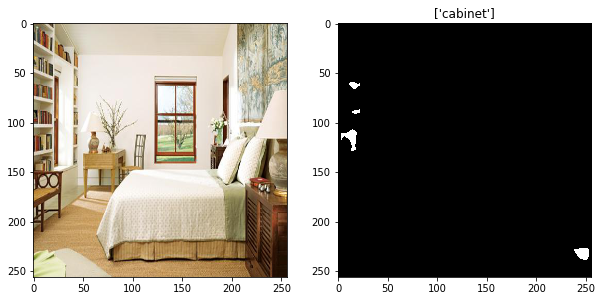

0.0311737060546875


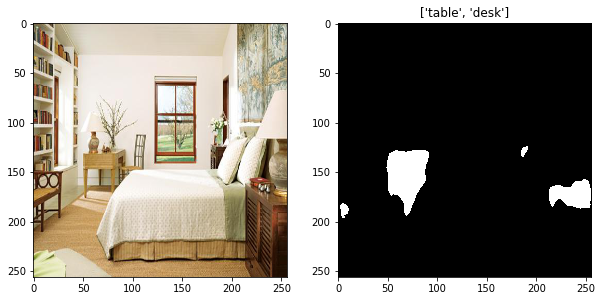

0.0


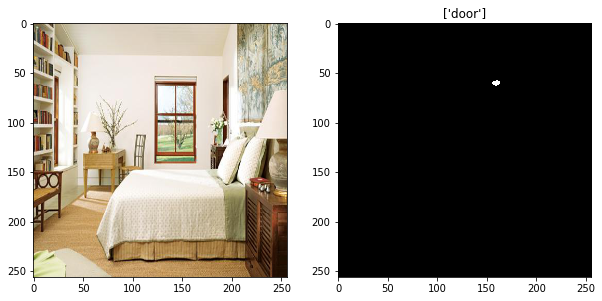

0.0


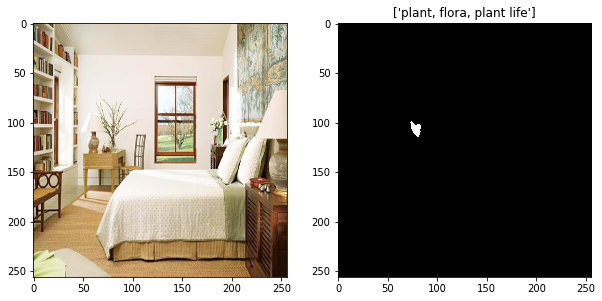

0.20123291015625


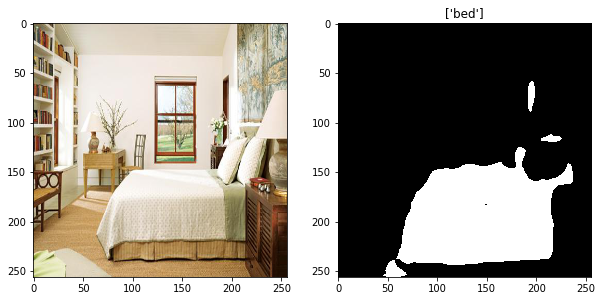

0.0215301513671875


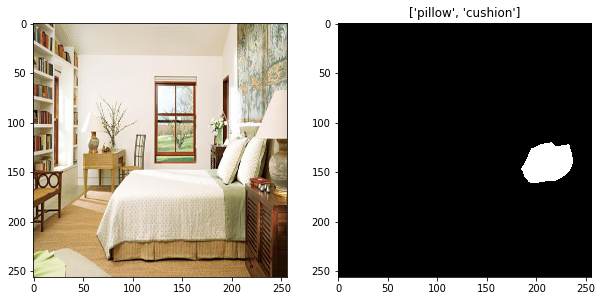

0.0057525634765625


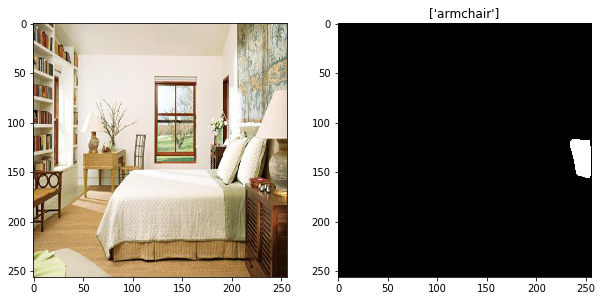

0.0


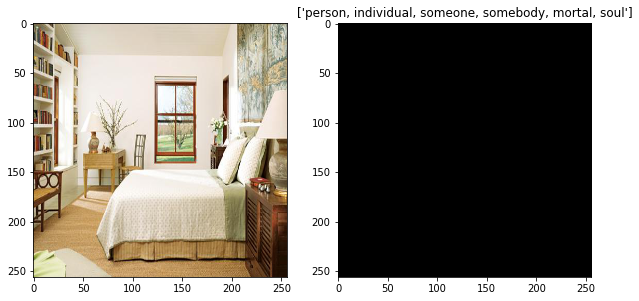

0.017120361328125


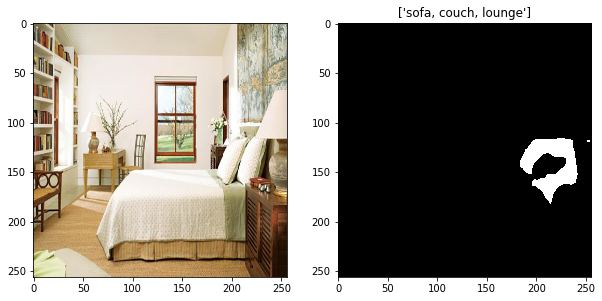

0.0


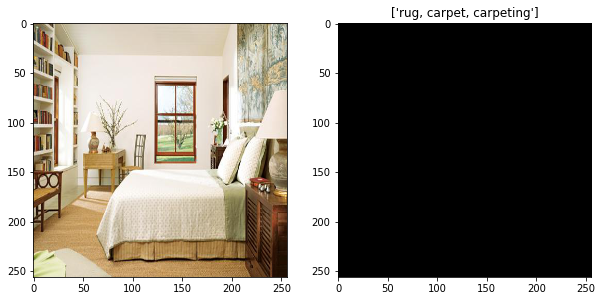

0.0


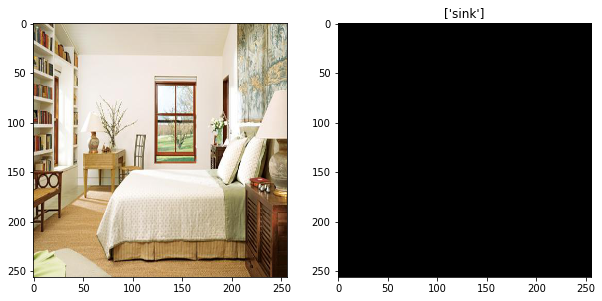

0.0


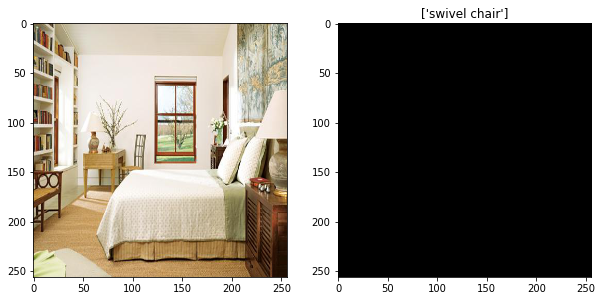

0.0


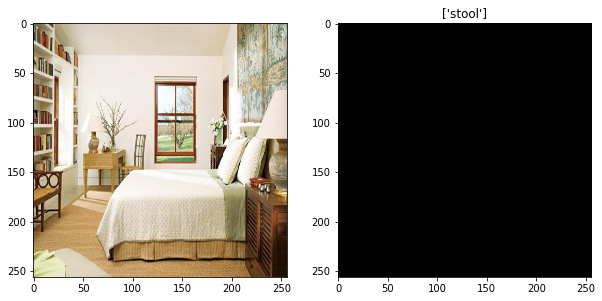

0.0


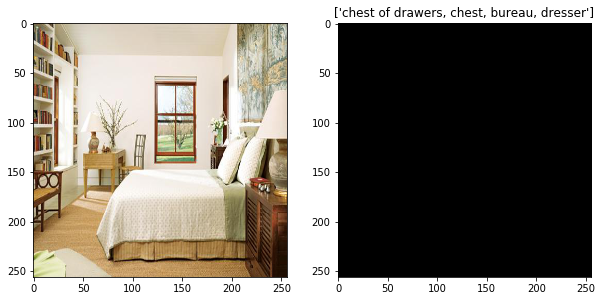

0.0


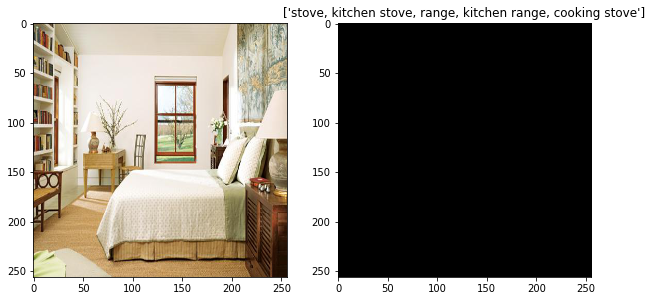

0.0


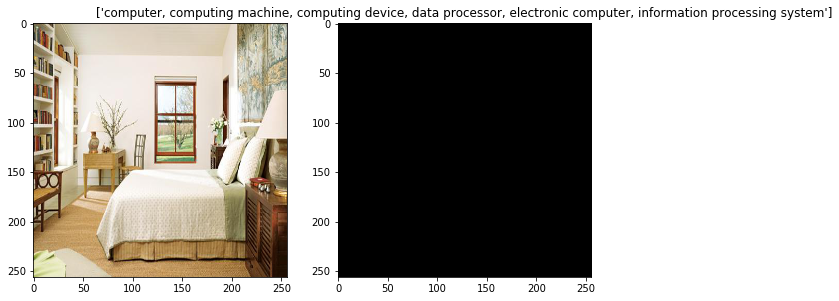

0.0


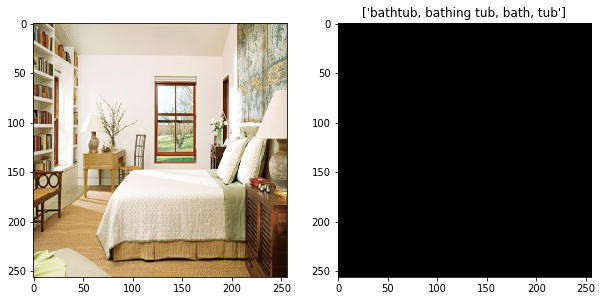

0.0


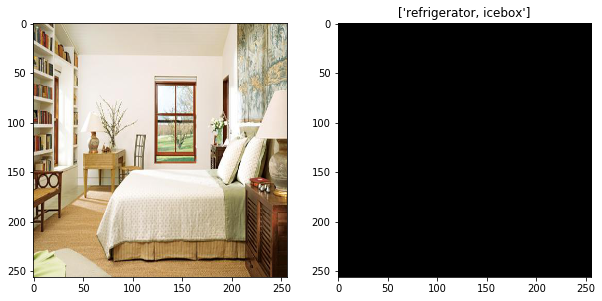

0.0034027099609375


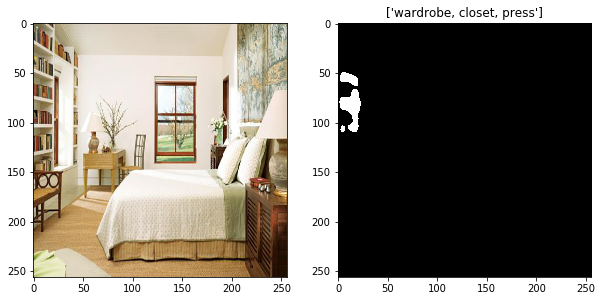

0.0


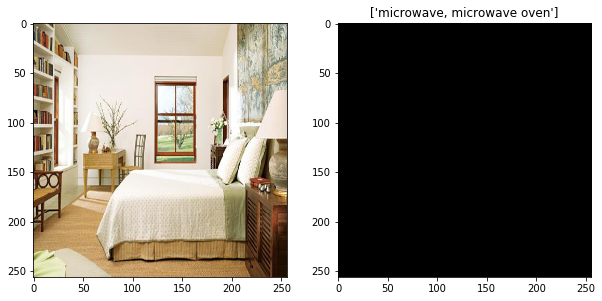

0.0


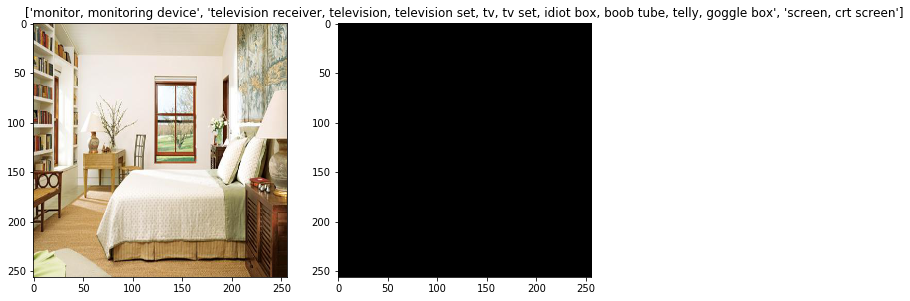

0.0


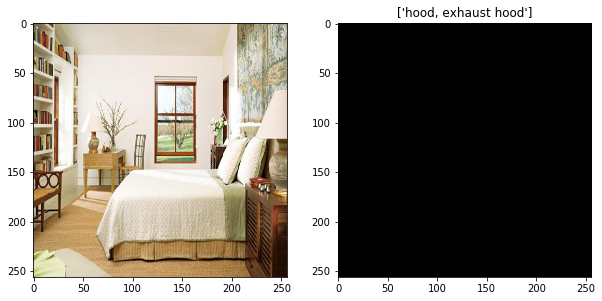

0.0


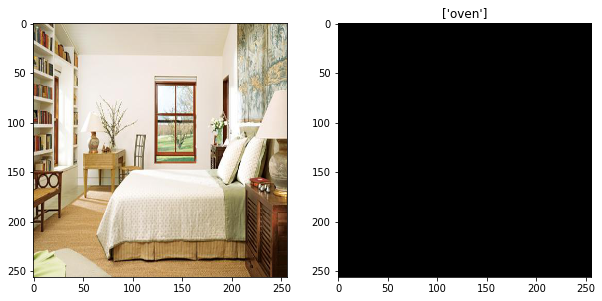

0.0


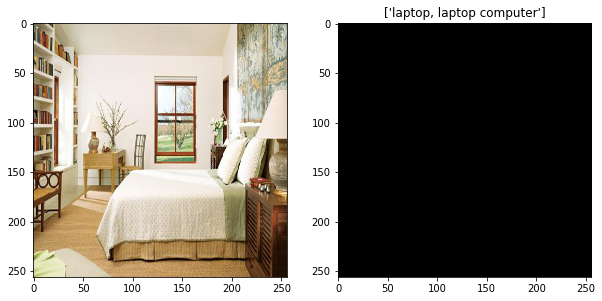

0.0


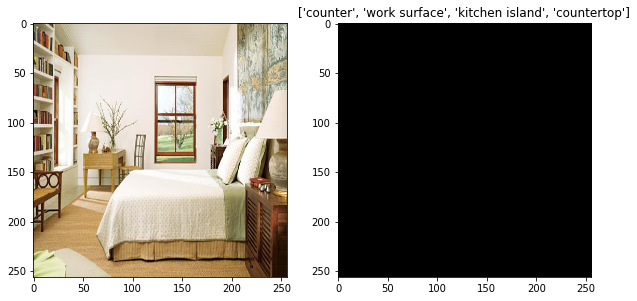

0.0


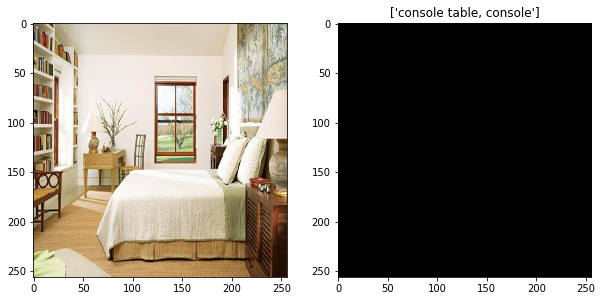

0.0


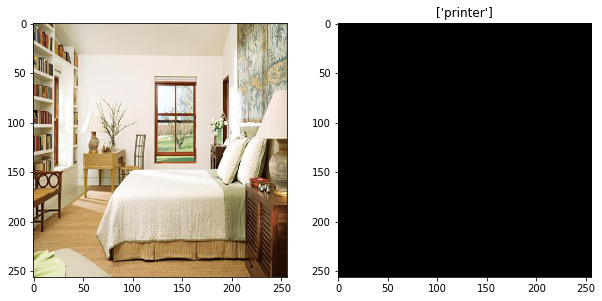

0.0


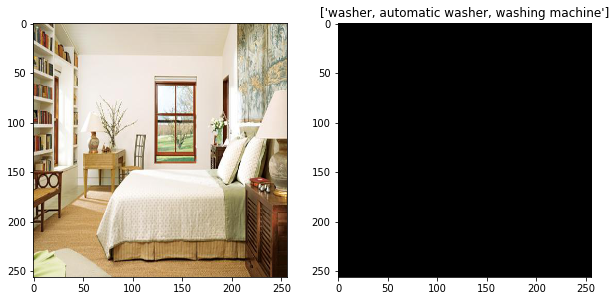

In [266]:
img, pred = pred_img(val_dir + "/img/00001152.jpg")

In [248]:
path = val_dir + "/img/00001152.jpg"
img = imread(path)
h, w, c = img.shape
img = cv2.resize(img, (img_shape, img_shape)) / 255
pred = model.predict(np.array([img]))[0]

In [262]:
for i, channel in zip(range(0, classes_num), np.moveaxis(pred, 2, 0)):
    print(cl.class_list[i][0] + ": " + str(int(channel.sum()/channel.shape[0]**2 * 100)) + "%")

-: 68%
chair: 2%
painting, picture: 0%
cabinet: 1%
table: 4%
door: 0%
plant, flora, plant life: 0%
bed: 21%
pillow: 2%
armchair: 0%
person, individual, someone, somebody, mortal, soul: 0%
sofa, couch, lounge: 2%
rug, carpet, carpeting: 0%
sink: 0%
swivel chair: 0%
stool: 0%
chest of drawers, chest, bureau, dresser: 0%
stove, kitchen stove, range, kitchen range, cooking stove: 0%
computer, computing machine, computing device, data processor, electronic computer, information processing system: 0%
bathtub, bathing tub, bath, tub: 0%
refrigerator, icebox: 0%
wardrobe, closet, press: 0%
microwave, microwave oven: 0%
monitor, monitoring device: 0%
hood, exhaust hood: 0%
oven: 0%
laptop, laptop computer: 0%
counter: 0%
console table, console: 0%
printer: 0%
washer, automatic washer, washing machine: 0%


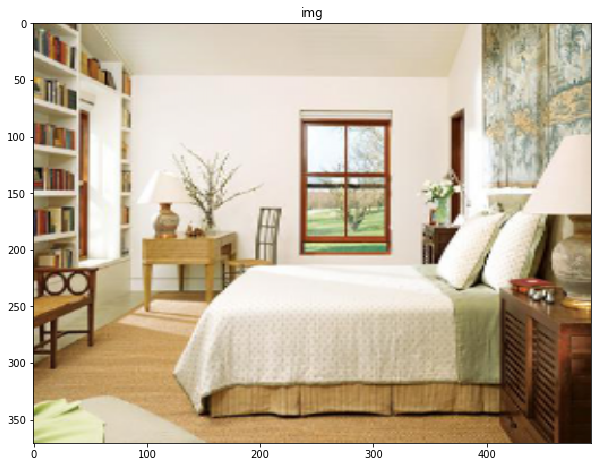

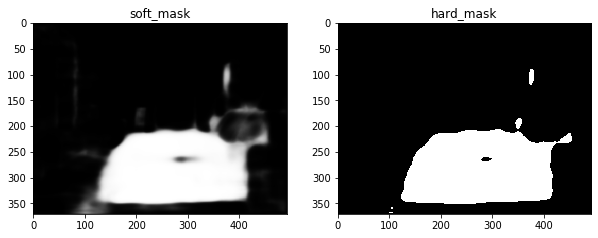

In [249]:
mask = pred[:, :, 7]
original_img = cv2.resize(img, (w, h))
mask = cv2.resize(mask, (w, h))

# Изображение
plt.figure(figsize=(10, 10))
plt.imshow(original_img), plt.title("img")
plt.show()

# Маски
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(mask, "gray"), plt.title("soft_mask")
plt.subplot(122), plt.imshow(mask > 0.5, "gray"), plt.title('hard_mask')
plt.show()

In [163]:
def f(mask):
    hard_mask = mask > 0.5
    hard_mask = np.float32(hard_mask)
    r0 = get_r0(mask)
    
    dist_arr = []
    xy_arr = []
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 1:
                r = np.array([i, j])
                xy_arr.append(r0 - r)
                dist_arr.append(dist(r0, r))

    dist_arr = np.array(dist_arr)
    xy_arr = np.array(xy_arr)
    
    return dist_arr, xy_arr

In [159]:
def get_r0(mask):
    r0 = np.array([0, 0])

    h, w = mask.shape
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 1:
                r0 += np.array([i, j])
    r0 = r0 // mask.sum()
    return r0



In [164]:
dist, xy = f(mask)

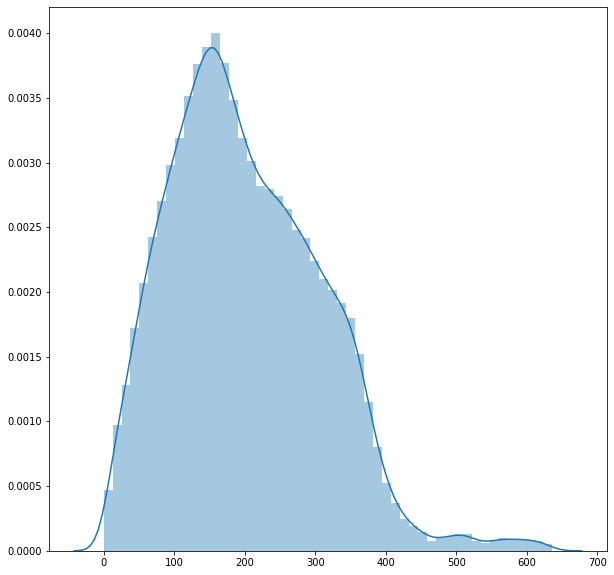

In [181]:
plt.figure(figsize=(10, 10))
sns.distplot(dist)
plt.show()

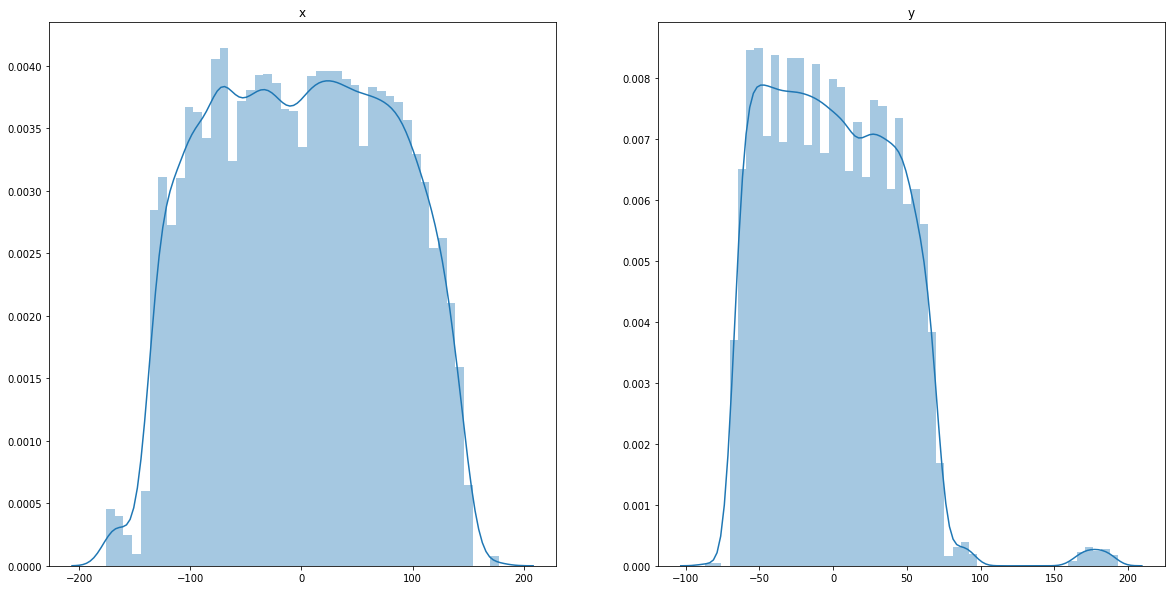

In [174]:
# Маски
plt.figure(figsize=(20, 10))
plt.subplot(121), sns.distplot(xy[:, 1]), plt.title("x")
plt.subplot(122), sns.distplot(xy[:, 0]), plt.title('y')
plt.show()

In [236]:
alpha = 0.01

q_ly = np.quantile(xy_arr[:, 0], q=alpha)
q_ry = np.quantile(xy_arr[:, 0], q=1 - alpha)

q_lx = np.quantile(xy_arr[:, 1], q=alpha)
q_rx = np.quantile(xy_arr[:, 1], q=1 - alpha)

In [237]:
filt_mask = mask.copy()

In [238]:
for i in range(h):
    for j in range(w):
        if mask[i, j] == 1:
            if not (q_ly < i - r0[0] < q_ry) or not (q_lx < j - r0[1] < q_rx):
                filt_mask[i, j] = 0

In [239]:
empty = np.zeros(mask.shape)

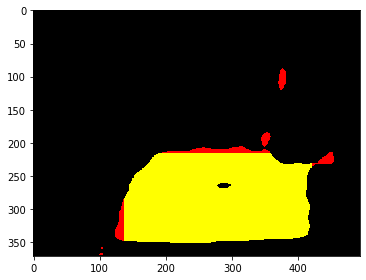

In [244]:
imshow(np.moveaxis(np.array([mask, filt_mask, empty]), 0, -1))

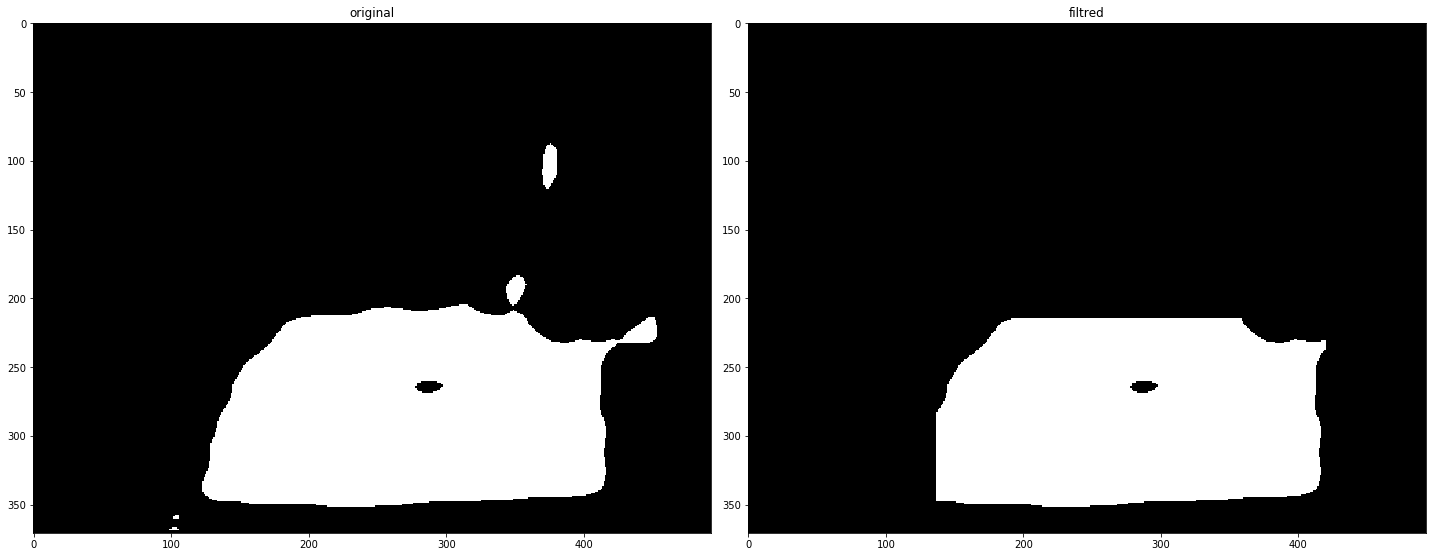

In [247]:
# Маски
plt.figure(figsize=(20, 10))
plt.subplot(121), imshow(mask), plt.title("original")
plt.subplot(122), imshow(filt_mask), plt.title('filtred')
plt.show()

TypeError: Invalid shape (36804,) for image data

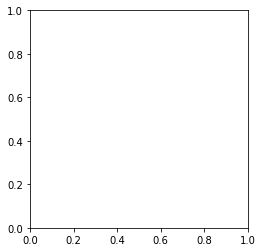

In [145]:
imshow(mask[mask == mask.max()])

In [117]:
mask.sum()

0.0

In [96]:
np.quantile(xy_arr[:, 0], q = 0.0)

-61.0

In [68]:
def dist(r1, r2):
    r = r2 - r1
    return (r[0]**2 + r[1]**2)**0.6

In [69]:
dist(r1, r2)

2.626527804403767

(256, 256)


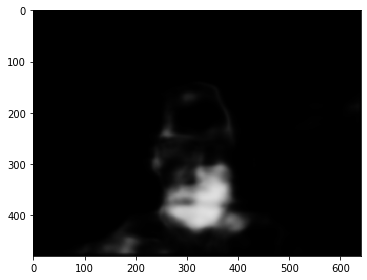

(256, 256)


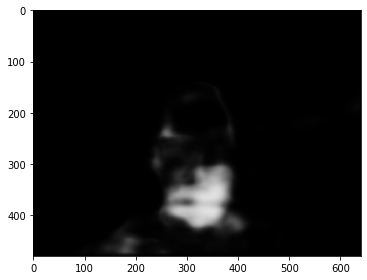

(256, 256)


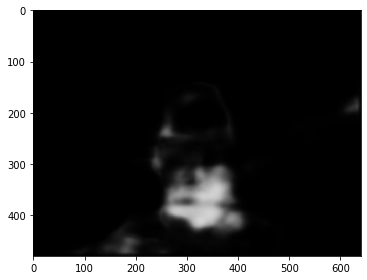

(256, 256)


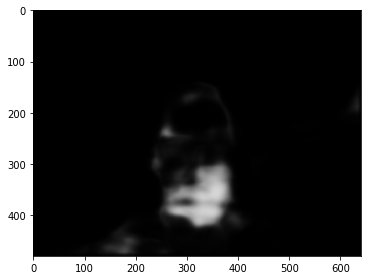

(256, 256)


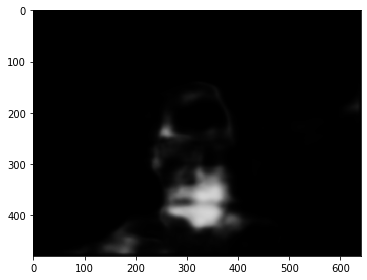

(256, 256)


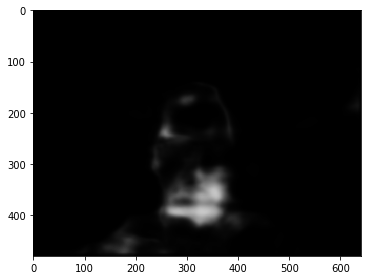

(256, 256)


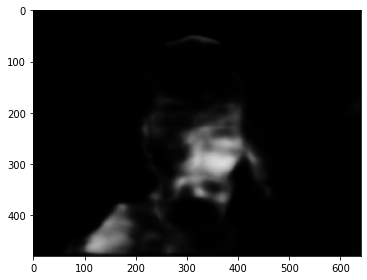

(256, 256)


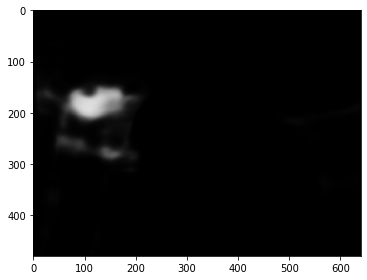

(256, 256)


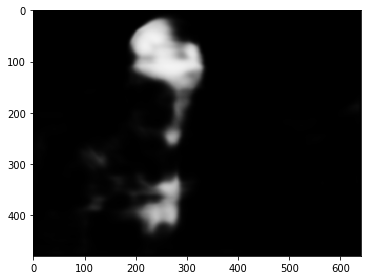

(256, 256)


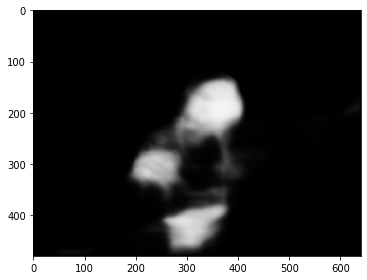

(256, 256)


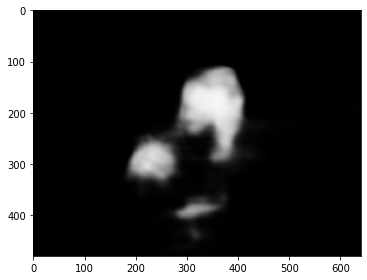

(256, 256)


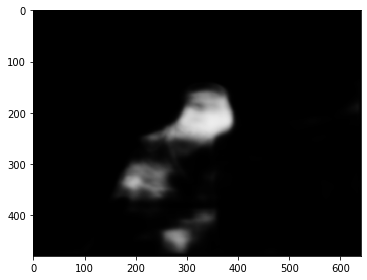

(256, 256)


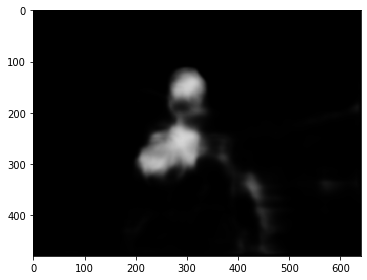

(256, 256)


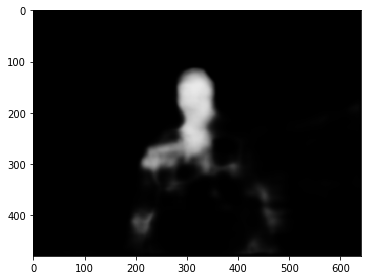

(256, 256)


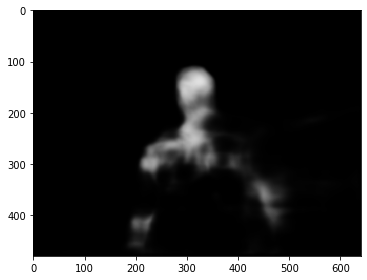

(256, 256)


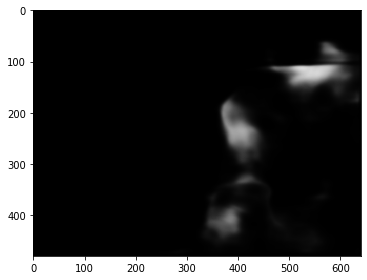

(256, 256)


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


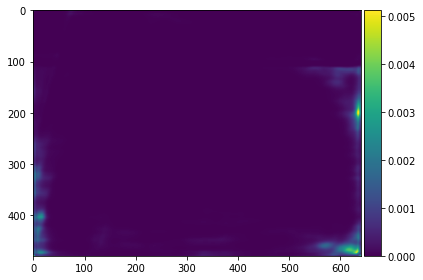

(256, 256)


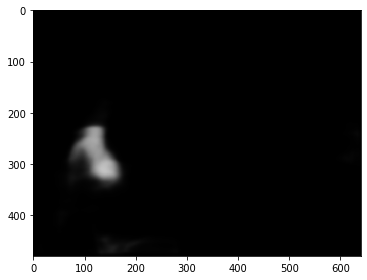

(256, 256)


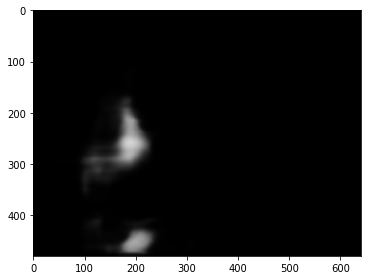

(256, 256)


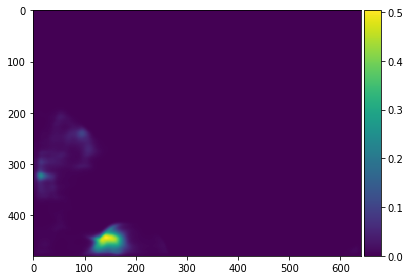

(256, 256)


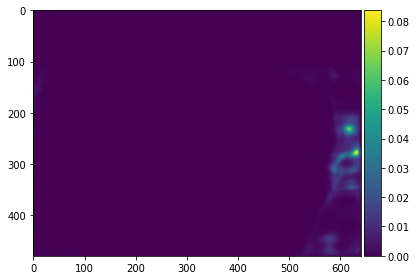

(256, 256)


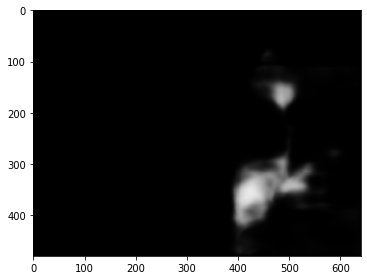

In [47]:
import pickle
import cv2

source = 'test.mp4'
cap = cv2.VideoCapture(0)
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue
        
        frame_h, frame_w, frame_c = frame.shape
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        frame = cv2.resize(frame, (img_shape, img_shape)) / 255
        
        pred = model.predict(np.array([frame]))[0]
        mask = pred[:, :, 10]
        
        print(mask.shape)
        mask = cv2.resize(mask, (frame_w, frame_h))
        imshow(mask)
        plt.show()
        
        time.sleep(1)
except:
    cap.release()